使い方
- 時系列データを作成してください
- その後データのパスを指定したのち、上から実行してください

##Prepare

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

In [ ]:
base_path = "/content/drive/My Drive/LAC/data/"

In [ ]:
with open(base_path+"fraud_ts.pkl", "rb") as f1, open(base_path+"fraud_d.pkl", "rb") as f2:
    X_train_ts, y_train_ts, X_test_ts, y_test_ts = pickle.load(f1)
    X_train, y_train, X_test, y_test = pickle.load(f2)

時系列/直接アプローチのデータのshape, 正常/異常のデータサイズ

In [ ]:
X_train_ts.shape, X_test_ts.shape, X_train.shape, X_test.shape

((1195796, 15, 8), (519373, 15, 8), (1195796, 8), (519373, 8))

In [ ]:
sum(y_train_ts == 0),sum(y_test_ts == 0), sum(y_train == 0), sum(y_test == 0)

(1189974, 517973, 1189974, 517973)

In [ ]:
sum(y_train_ts == 1),sum(y_test_ts == 1), sum(y_train == 1), sum(y_test == 1)

(5822, 1400, 5822, 1400)

In [ ]:
X_train_ts, X_train

(array([[[133.93, 42.718624334200896, -109.21441882696718, ..., 1.0, 1.0,
          1.0],
         [28.5, 43.14605661034977, -108.86511323257568, ..., 1.0, 1.0,
          1.0],
         [9.4, 43.32898144346698, -108.42872243237841, ..., 1.0, 1.0,
          7.0],
         ...,
         [79.51, 43.21833030392167, -108.60929059375738, ..., 1.0, 3.0,
          9.0],
         [63.91, 42.965826022019755, -109.23898121079979, ..., 1.0, 3.0,
          12.0],
         [53.6, 43.23618002987888, -108.78347028198064, ..., 1.0, 3.0,
          13.0]],
 
        [[28.5, 43.14605661034977, -108.86511323257568, ..., 1.0, 1.0,
          1.0],
         [9.4, 43.32898144346698, -108.42872243237841, ..., 1.0, 1.0,
          7.0],
         [60.03, 43.13892225103225, -108.98619402227399, ..., 1.0, 1.0,
          7.0],
         ...,
         [63.91, 42.965826022019755, -109.23898121079979, ..., 1.0, 3.0,
          12.0],
         [53.6, 43.23618002987888, -108.78347028198064, ..., 1.0, 3.0,
          13.0],
 

##Preprocess

In [ ]:
def resample(X_ts, y_ts, X, y, total_sample_size=40000):
    normal_ts = X_ts[y_ts==0]
    abnormal_ts = X_ts[y_ts==1]
    normal = X[y==0]
    abnormal = X[y==1]

    dim1 = normal_ts.shape[1] #window size
    dim2 = normal_ts.shape[2] #var len

    x_norm_ts = np.zeros([total_sample_size , dim1, dim2])
    y_norm_ts = np.zeros([total_sample_size , 1])
    x_norm = np.zeros([total_sample_size, dim2])
    y_norm = np.zeros([total_sample_size, 1])    
    count = 0   
    for i in range(total_sample_size):
        ind = np.random.randint(normal_ts.shape[0])
        
        data_ts = normal_ts[ind]
        data = normal[ind]
        
        x_norm_ts[count, :] = data_ts
        x_norm[count] = data
        
        y_norm_ts[count] = 0
        y_norm[count] = 0
        
        count += 1
            
    x_abnorm_ts = np.zeros([total_sample_size , dim1, dim2])
    y_abnorm_ts = np.zeros([total_sample_size, 1])
    x_abnorm = np.zeros([total_sample_size, dim2])
    y_abnorm = np.zeros([total_sample_size, 1])
    count = 0
    for i in range(total_sample_size):
        ind = np.random.randint(abnormal_ts.shape[0])
        
        data_ts = abnormal_ts[ind]
        data = abnormal[ind]
        
        x_abnorm_ts[count, :] = data_ts
        x_abnorm[count] = data
        
        y_abnorm_ts[count] = 1
        y_abnorm[count] = 1
        
        count += 1      

    X_ts_new = np.concatenate([x_norm_ts, x_abnorm_ts], axis=0)
    y_ts_new = np.concatenate([y_norm_ts, y_abnorm_ts], axis=0)
    X_new = np.concatenate([x_norm, x_abnorm], axis=0)
    y_new = np.concatenate([y_norm, y_abnorm], axis=0)

    return X_ts_new, y_ts_new, X_new, y_new

リサンプリング(不均衡データ対応、学習の高速化)

In [ ]:
X_train_ts_new, y_train_ts_new, X_train_new, y_train_new = resample(X_train_ts, y_train_ts, X_train, y_train)

In [ ]:
X_train_ts_new.shape, y_train_ts_new.shape, X_train_new.shape, y_train_new.shape

((80000, 15, 8), (80000, 1), (80000, 8), (80000, 1))

In [ ]:
sum(y_train_ts_new == 0), sum(y_train_ts_new == 1), sum(y_train_new == 0), sum(y_train_new == 1)

(array([40000]), array([40000]), array([40000]), array([40000]))

##Train

###AttLSTM-CNN

In [ ]:
window_size = X_train_ts.shape[1]
variable_len = X_train_ts.shape[2]

In [ ]:
class Attention(tf.keras.layers.Layer):
  def __init__(self, units=256):
    super(Attention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)

  def call(self, values):
    score = self.W1(values) * values
    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
n_hidden = 256 #隠れベクトルの長さ

input_tensor = layers.Input(shape=(window_size, variable_len))  #batch_size x time_step x variable_length
l = layers.LSTM(n_hidden, batch_input_shape=(None, window_size, variable_len), return_sequences=True)(input_tensor)
l = layers.Reshape((window_size, n_hidden))(l)
l = layers.LSTM(n_hidden, batch_input_shape=(None, window_size, variable_len), return_sequences=True)(l)
l, _ = Attention(n_hidden)(l)

c = layers.Conv1D(16, 3, activation='relu', input_shape=(window_size, variable_len))(input_tensor)
c = layers.Dropout(.2)(c)
c = layers.Reshape((-1,))(c)

l_c = layers.Concatenate()([l, c])
x = layers.Dense(n_hidden)(l_c)
output_tensor = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs=input_tensor, outputs=output_tensor)

optimizer = optimizers.Adam(amsgrad=True)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model.fit(X_train_ts_new.astype("float32"), 
        y_train_ts_new.astype("float32"),
        batch_size=300,
        epochs=10,
        validation_split=0.1)

Epoch 1/10
240/240 [==============================] - 39s 18ms/step - loss: 2.3596 - precision: 0.7170 - recall: 0.6973 - val_loss: 0.4760 - val_precision: 1.0000 - val_recall: 0.7972
Epoch 2/10
240/240 [==============================] - 3s 13ms/step - loss: 0.6633 - precision: 0.8060 - recall: 0.7466 - val_loss: 0.7288 - val_precision: 1.0000 - val_recall: 0.7606
Epoch 3/10
240/240 [==============================] - 3s 13ms/step - loss: 0.3848 - precision: 0.8762 - recall: 0.8439 - val_loss: 0.1779 - val_precision: 1.0000 - val_recall: 0.9399
Epoch 4/10
240/240 [==============================] - 3s 13ms/step - loss: 0.2762 - precision: 0.8974 - recall: 0.8794 - val_loss: 0.2544 - val_precision: 1.0000 - val_recall: 0.9034
Epoch 5/10
240/240 [==============================] - 3s 13ms/step - loss: 0.2462 - precision: 0.9100 - recall: 0.8932 - val_loss: 0.3766 - val_precision: 1.0000 - val_recall: 0.8601
Epoch 6/10
240/240 [==============================] - 3s 13ms/step - loss: 0.2045 - 

In [ ]:
pred_proba = model.predict(X_test_ts.astype("float32"))

In [ ]:
y_true = y_test_ts.astype("float32")

In [ ]:
print(classification_report(y_true, np.round(pred_proba)))

              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97    517973
         1.0       0.04      0.89      0.08      1400

    accuracy                           0.94    519373
   macro avg       0.52      0.92      0.52    519373
weighted avg       1.00      0.94      0.97    519373



Text(83.40000000000006, 0.5, 'true')

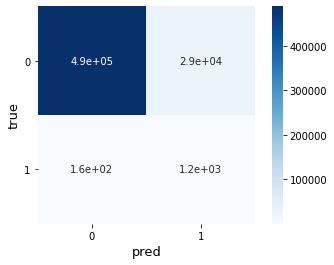

In [ ]:
cm = confusion_matrix(y_true, np.round(pred_proba))
cm = pd.DataFrame(data=cm, index=[0, 1], columns=[0, 1])
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')
plt.yticks(rotation=0)
plt.xlabel("pred", fontsize=13, rotation=0)
plt.ylabel("true", fontsize=13)

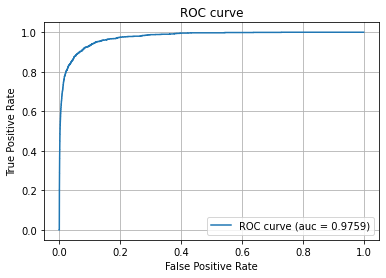

In [ ]:
#ROC曲線
# FPR, TPR(, しきい値) を算出
fpr, tpr, thresholds = roc_curve(y_true, pred_proba)

# AUC
auc_score = auc(fpr.astype("float32"), tpr.astype("float32"))

# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (auc = %.4f)'%auc_score)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

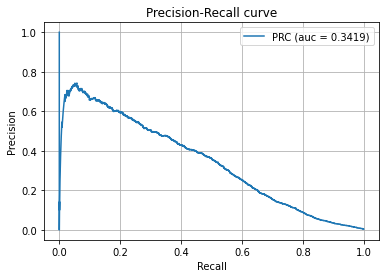

In [ ]:
#PRC
precision, recall, thresholds = precision_recall_curve(y_test, pred_proba)

auc_score = auc(recall.astype("float32"), precision.astype("float32"))

plt.plot(recall, precision, label='PRC (auc = %.4f)'%auc_score)
plt.legend()
plt.title('Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

###AttLSTM-CNN(Residual Connection)

In [ ]:
window_size = X_train_ts.shape[1]
variable_len = X_train_ts.shape[2]

In [ ]:
class Attention(tf.keras.layers.Layer):
  def __init__(self, units=256):
    super(Attention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)

  def call(self, values):
    score = self.W1(values) * values
    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
n_hidden = 256 #隠れベクトルの長さ

input_tensor_ts = layers.Input(shape=(window_size, variable_len))  #batch_size x time_step x variable_length
l = layers.LSTM(n_hidden, batch_input_shape=(None, window_size, variable_len), return_sequences=True)(input_tensor_ts)
l = layers.Reshape((window_size, n_hidden))(l)
l = layers.LSTM(n_hidden, batch_input_shape=(None, window_size, variable_len), return_sequences=True)(l)
l, _ = Attention(n_hidden)(l)

c = layers.Conv1D(16, 3, activation='relu', input_shape=(window_size, variable_len))(input_tensor_ts)
c = layers.Dropout(.2)(c)
c = layers.Reshape((-1,))(c)

input_tensor = layers.Input(shape=(variable_len))
res = layers.Reshape((-1,))(input_tensor)

l_c_res = layers.Concatenate()([l, c, res])
x = layers.Dense(n_hidden)(l_c_res)
output_tensor = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs=[input_tensor_ts, input_tensor], outputs=output_tensor)

optimizer = optimizers.Adam(amsgrad=True)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model.fit([X_train_ts_new.astype("float32"), X_train_new.astype("float32")], 
        y_train_ts_new.astype("float32"),
        batch_size=300,
        epochs=10,
        validation_split=0.1)

Epoch 1/10
240/240 [==============================] - 7s 17ms/step - loss: 2.8514 - precision_1: 0.7486 - recall_1: 0.7329 - val_loss: 0.1502 - val_precision_1: 1.0000 - val_recall_1: 0.9772
Epoch 2/10
240/240 [==============================] - 3s 14ms/step - loss: 0.7004 - precision_1: 0.8074 - recall_1: 0.7678 - val_loss: 0.1718 - val_precision_1: 1.0000 - val_recall_1: 0.9164
Epoch 3/10
240/240 [==============================] - 3s 14ms/step - loss: 0.4652 - precision_1: 0.8678 - recall_1: 0.8023 - val_loss: 0.2916 - val_precision_1: 1.0000 - val_recall_1: 0.8777
Epoch 4/10
240/240 [==============================] - 3s 14ms/step - loss: 0.3196 - precision_1: 0.9080 - recall_1: 0.8558 - val_loss: 0.1529 - val_precision_1: 1.0000 - val_recall_1: 0.9374
Epoch 5/10
240/240 [==============================] - 3s 14ms/step - loss: 0.2477 - precision_1: 0.9145 - recall_1: 0.8823 - val_loss: 0.2149 - val_precision_1: 1.0000 - val_recall_1: 0.9069
Epoch 6/10
240/240 [=========================

In [ ]:
pred_proba = model.predict([X_test_ts.astype("float32"),X_test.astype("float32")])

In [ ]:
y_true = y_test_ts.astype("float32")

In [ ]:
print(classification_report(y_true, np.round(pred_proba)))

              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97    517973
         1.0       0.04      0.89      0.08      1400

    accuracy                           0.94    519373
   macro avg       0.52      0.92      0.53    519373
weighted avg       1.00      0.94      0.97    519373



Text(83.40000000000006, 0.5, 'true')

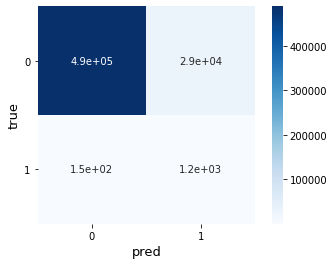

In [ ]:
cm = confusion_matrix(y_true, np.round(pred_proba))
cm = pd.DataFrame(data=cm, index=[0, 1], columns=[0, 1])
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')
plt.yticks(rotation=0)
plt.xlabel("pred", fontsize=13, rotation=0)
plt.ylabel("true", fontsize=13)

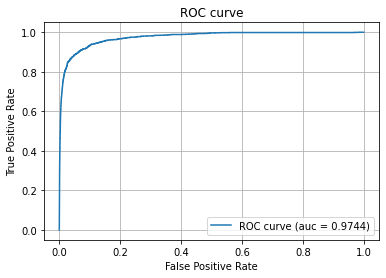

In [ ]:
#ROC曲線
# FPR, TPR(, しきい値) を算出
fpr, tpr, thresholds = roc_curve(y_true, pred_proba)

# AUC
auc_score = auc(fpr.astype("float32"), tpr.astype("float32"))

# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (auc = %.4f)'%auc_score)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

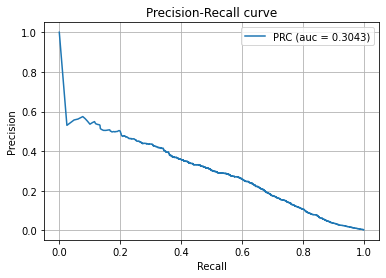

In [ ]:
#PRC
precision, recall, thresholds = precision_recall_curve(y_test, pred_proba)

auc_score = auc(recall.astype("float32"), precision.astype("float32"))

plt.plot(recall, precision, label='PRC (auc = %.4f)'%auc_score)
plt.legend()
plt.title('Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()